In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from goexplore import *

In [4]:
archive = np.load('data/ge/archive_MontezumaRevenge_0.npy', allow_pickle=True).item()

In [5]:
cells = list(archive.values())
rets = [cell.running_ret for cell in cells]
cells_best = [cell for cell in cells if cell.running_ret==np.max(rets)]
print(f'Max running return found: {np.max(rets)}')
print(f'Total cells: {len(cells)}')
print(f'Total cells: {len(cells_best)}')

Max running return found: 500.0
Total cells: 2024
Total cells: 35


In [6]:
cell = cells_best[0]

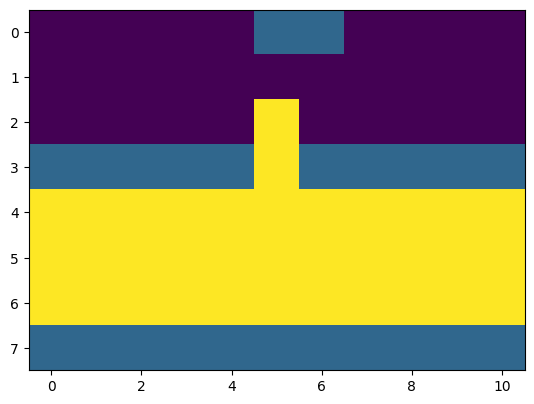

In [7]:
plt.imshow(np.array(cell.cell_raw).reshape(8, 11))

In [8]:
class GEBuffer(Buffer):
    def __init__(self, env, n_steps, device=None):
        super().__init__(env, n_steps, device=device)
        self.trajs = [None for _ in range(self.env.n_envs)]
        self.traj_lens = np.zeros(self.env.n_envs, dtype=int)
        self.i_locs = np.zeros(self.env.n_envs, dtype=int)
        
    def sample_new_traj(self, ids, sample_traj_fn):
        for id in ids:
            self.trajs[id] = sample_traj_fn()
            self.traj_lens[id] = len(self.trajs[id])
            self.i_locs[id] = 0
        obs, _ = self.env.reset_subenvs(ids)
        self.next_obs[ids] = torch.from_numpy(obs).to(self.device)
    
    def gecollect(self, sample_traj_fn, pbar=None):
        if self.first_collect:
            self.first_collect = False
            _, info = env.reset()
            self.next_obs = info['obs']
            self.sample_new_traj(np.arange(self.env.num_envs), sample_traj_fn)
        for t in range(self.n_steps):
            self.obss[:, t] = self.next_obs
            action = np.array([traj[i_loc] for traj, i_loc in zip(self.trajs, self.i_locs)])
            self.i_locs += 1
            self.acts[:, t] = torch.from_numpy(action)
            _, _, _, _, info = env.step(action)
            self.next_obs = info['obs']
            self.sample_new_traj(np.where(self.i_locs>=self.traj_lens)[0], sample_traj_fn)


In [9]:
len(cell.trajectory)

662

In [13]:
np.random.seed(0)
torch.manual_seed(0)
env = MyEnvpool('MontezumaRevenge-v5', num_envs=4, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env = ToTensor(env)
gebuff = GEBuffer(env, 662, None)
gebuff.gecollect(sample_traj_fn=lambda : cell.trajectory)

In [14]:
gebuff.obss.shape

torch.Size([4, 662, 1, 84, 84])

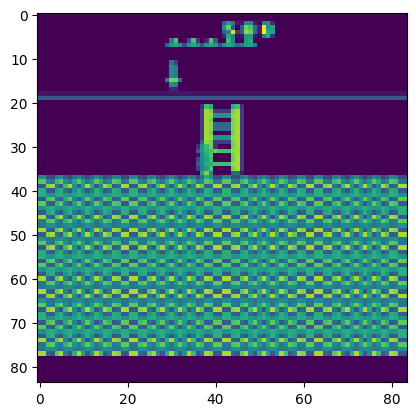

In [15]:
plt.imshow(gebuff.obss[0, -1, 0])

In [7]:
with open('atari_games_104.txt') as f:
    env_ids = [a.strip() for a in f.readlines()]
with open('atari_games_ignore.txt') as f:
    env_ids_ignore = [a.strip() for a in f.readlines()]
env_ids = [a for a in env_ids if a not in env_ids_ignore]
for env_id in env_ids:
    print(env_id)
    env = MyEnvpool(f'{env_id}-v5', full_action_space=True, use_fire_reset=False, num_envs=8, img_height=84, img_width=84, gray_scale=True, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1)
    obs, _ = env.reset()
    for i in range(100):
        action = np.random.randint(0, 18, env.num_envs)
        action[action==1] = 0
        obs, _, _, _, _ = env.step(action)
    
    if not obs.var(axis=0).max()>0.:
        print(f'--------{env_id} NEEDS FIRE RESET -------------------')

Adventure
AirRaid
Alien
Amidar
Assault
Asterix
Asteroids
Atlantis
Atlantis2
Backgammon
BankHeist
BasicMath
BattleZone
BeamRider
Berzerk
Blackjack
Bowling
Boxing
Breakout
Carnival
Casino
Centipede
ChopperCommand
CrazyClimber
Crossbow
Darkchambers
Defender
DemonAttack
DonkeyKong
DoubleDunk
Earthworld
ElevatorAction
Enduro
Entombed
Et
FishingDerby
FlagCapture
Freeway
Frostbite
Galaxian
Gopher
Gravitar
Hangman
HauntedHouse
Hero
HumanCannonball
IceHockey
Jamesbond
JourneyEscape
Kaboom
Kangaroo
KeystoneKapers
Klax
Koolaid
Krull
KungFuMaster
LaserGates
MarioBros
MiniatureGolf
MontezumaRevenge
MrDo
MsPacman
NameThisGame
Othello
Pacman
Phoenix
Pitfall
Pitfall2
Pong
Pooyan
PrivateEye
Qbert
Riverraid
RoadRunner
Robotank
Seaquest
SirLancelot
Solaris
SpaceInvaders
SpaceWar
StarGunner
Superman
Surround
Tennis
Tetris
TicTacToe3d
TimePilot
Trondead
Turmoil
Tutankham
UpNDown
Venture
VideoCheckers
VideoChess
VideoCube
VideoPinball
WizardOfWor
WordZapper
YarsRevenge
Zaxxon
